# Quantum Map Spectrum

In [1]:
import sys
sys.path.insert(0, '../../src/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random

import pickle
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from src import *
#np.set_printoptions(threshold=sys.maxsize)

## Random Choi Map Spectrum

In [54]:
n = 2
d = 2**n
rank = 2

np.random.seed(42)
choi_target = ChoiMap(d, rank)
input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]
target_list = [choi_target.apply_map(state) for state in input_list]
choi_model = ChoiMap(d, rank)
model = ModelQuantumMap(q_map = choi_model,
                        cost = state_density_loss,
                        input_list = input_list,
                        target_list = target_list,
                        lr = 0.025, 
                        h = 1e-4)

spectrum = choi_spectrum(choi_target.choi, pairs = True)
spectrum1 = choi_spectrum(choi_model.choi, pairs = True)

In [55]:
model.train(num_iter = 100,
            use_adam = True,
            verbose = False,
            N = 1)
spectrum2 = choi_spectrum(choi_model.choi, pairs = True)

model.train(num_iter = 100,
            use_adam=True,
            verbose = False,
            N = 1)
spectrum3 = choi_spectrum(choi_model.choi, pairs = True)

model.train(num_iter = 100,
            use_adam = True,
            verbose = False,
            N = 1)
spectrum4 = choi_spectrum(choi_model.choi, pairs = True)

model.train(num_iter = 100,
            use_adam=True,
            verbose = False,
            N = 1)
spectrum5 = choi_spectrum(choi_model.choi, pairs = True)

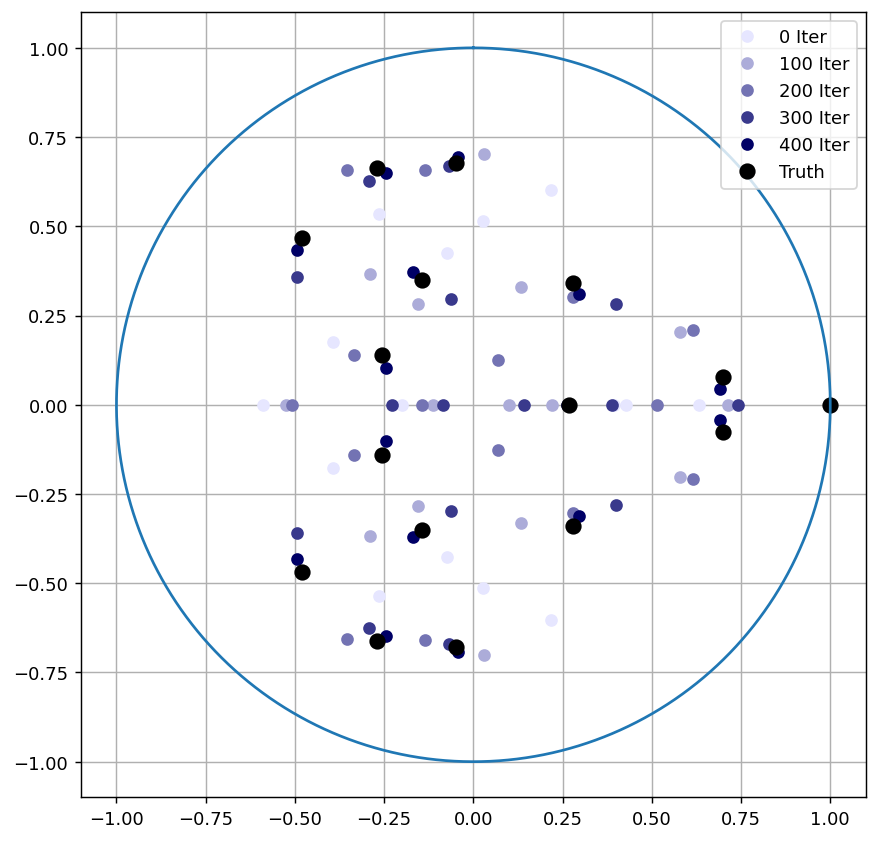

In [68]:
#spectrum_list = np.array([spectrum1, spectrum2, spectrum3, spectrum4, spectrum5, spectrum6, spectrum7])
#print(spectrum_list.shape)
t = np.linspace(0, 2*np.pi, 1000)
circle = [np.sin(t), np.cos(t)]
      
fig = plt.figure(figsize=(12,8), dpi = 130, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

a = np.linspace(0.9, 0, 5)
b = np.linspace(1, 0.4, 5)

c = list(zip(a, a, b))

plt.plot(spectrum1[0], spectrum1[1], "o", color = c[0], markersize=6)
plt.plot(spectrum2[0], spectrum2[1], "o", color = c[1], markersize=6)
plt.plot(spectrum3[0], spectrum3[1], "o", color = c[2], markersize=6)
plt.plot(spectrum4[0], spectrum4[1], "o", color = c[3], markersize=6)
plt.plot(spectrum5[0], spectrum5[1], "o", color = c[4], markersize=6)



plt.plot(spectrum[0], spectrum[1], "ko", markersize=8)
plt.legend(["0 Iter", "100 Iter", "200 Iter", "300 Iter", "400 Iter", "Truth"], loc="upper right")
plt.plot(*circle)
plt.grid()

plt.show()